In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=2


In [2]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
import numpy as np
import pandas as pd
import cudf as gd
from cuml.manifold.umap import UMAP as cumlUMAP
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.autonotebook import tqdm
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir

In [5]:
from avgn.utils.paths import FIGURE_DIR, ensure_dir
from avgn.utils.general import save_fig

In [6]:
DATASET_ID = 'buckeye'

In [7]:
window_loc = DATA_DIR / "umap_windows/buckeye/talk_take_4.pickle"

In [8]:
words_df = pd.read_pickle(window_loc)

In [9]:
words_df[:3]

start_time    end_time  word      phones  \
74    50.261883   50.568774  talk  [t, ao, k]   
178   99.314583   99.484905  take  [t, ey, k]   
227  116.483044  116.734831  take  [t, ey, k]   

                                   phone_start_times  \
74   [0.0, 0.15110900000000527, 0.23211600000000487]   
178   [0.0, 0.0757289999999955, 0.13864599999999427]   
227  [0.0, 0.10627999999999815, 0.20560199999999895]   

                                       phone_end_times  utterance_number  \
74   [0.15110900000000527, 0.23211600000000487, 0.3...                15   
178  [0.0757289999999955, 0.13864599999999427, 0.17...                16   
227  [0.10627999999999815, 0.20560199999999895, 0.2...                64   

     position_in_utterance  word_number indv  indvi age sex     key   rate  \
74                       7            7  s25      0   o   f  s2501b  16000   
178                      7            7  s25      0   o   f  s2501b  16000   
227                     27           27  s25      0   o   f  s2501b  16000   

                                           spectrogram  \
74   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
178  [[13, 13, 14, 14, 11, 9, 28, 59, 118, 156, 175...   
227  [[96, 117, 120, 112, 97, 75, 41, 7, 1, 0, 0, 0...   

                                               windows  
74   [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...  
178  [[[13, 33, 0, 0, 11, 1, 0, 0, 0, 0, 0, 0, 0, 0...  
227  [[[96, 126, 59, 85, 67, 55, 63, 58, 53, 55, 58...

In [10]:
len(words_df)

512

In [11]:
word_group = '_'.join(words_df.word.unique())
word_group

'talk_take'

In [12]:
FIG_SAVE_LOC = FIGURE_DIR/'umap_seqs' / DATASET_ID / word_group
ensure_dir(FIG_SAVE_LOC)

In [13]:
pd.DataFrame({i:[sum(words_df.indv ==i)] for i in  words_df.indv.unique()})

s25  s08  s24  s15  s16  s35  s19  s18  s23  s26  ...  s29  s09  s31  s39  \
0   17   11   16   19   22   14   23   12   10    9  ...   13    4   11   19   

   s04  s17  s37  s21  s40  s33  
0   20    5    8   16    2    5  

[1 rows x 40 columns]

In [14]:
np.unique(np.concatenate(words_df.phones.values))

array(['aa', 'ah', 'ao', 'ay', 'eh', 'ey', 'g', 'hh', 'ih', 'iy', 'k',
       'ow', 's', 't', 'tq', 'uh'], dtype='<U2')

In [15]:
n_windows = [len(row.windows) for idx, row in words_df.iterrows()]
words = np.concatenate([np.repeat(row.word, len(row.windows)) for idx, row in words_df.iterrows()])

In [16]:
n_windows[:5]

[77, 43, 63, 75, 73]

In [17]:
# get beginnings and endings of each sequence
onsets = [0]
offsets = [n_windows[0]-1]
for wd in n_windows[1:]:
    onsets.append(offsets[-1]+1)
    offsets.append(onsets[-1]+wd-1)
onsets[:5], offsets[:5], len(onsets), len(offsets)

([0, 77, 120, 183, 258], [76, 119, 182, 257, 330], 512, 512)

In [18]:
{i:sum(words == i) for i in np.unique(words)}

{'take': 20817, 'talk': 12731}

In [19]:
words[:10]

array(['talk', 'talk', 'talk', 'talk', 'talk', 'talk', 'talk', 'talk',
       'talk', 'talk'], dtype='<U4')

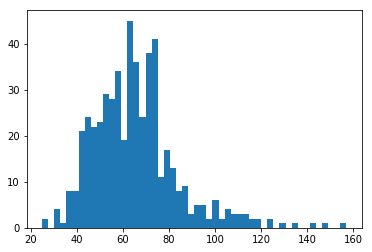

In [20]:
plt.hist(n_windows, bins=50);

In [21]:
rate = 16000

In [22]:
windows = np.vstack(list(words_df.windows))
print(np.shape(windows))
windows = np.reshape(windows, (len(windows), np.prod(np.shape(windows)[1:])))
print(np.shape(windows))

(33548, 1, 32)
(33548, 32)


In [23]:
cuml_umap = cumlUMAP(min_dist = 0.25)
embedding = cuml_umap.fit_transform(windows)

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  """Entry point for launching an IPython kernel.
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  


(-15, 15)

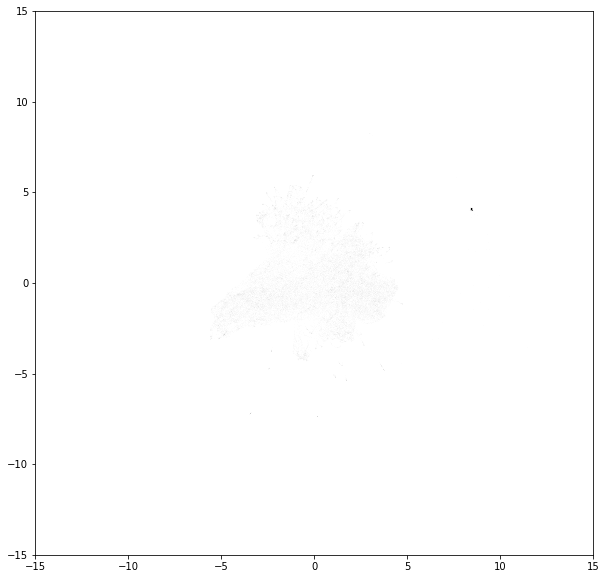

In [24]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(embedding[:,0], embedding[:,1], alpha = 0.0025, s = 1, color='k')
ax.set_xlim([-15,15])
ax.set_ylim([-15,15])

### plot over time

In [25]:
savefig = False

In [26]:
from avgn.visualization.projections import colorline

In [27]:
xlims = [-6,8]
ylims = [-6,6]

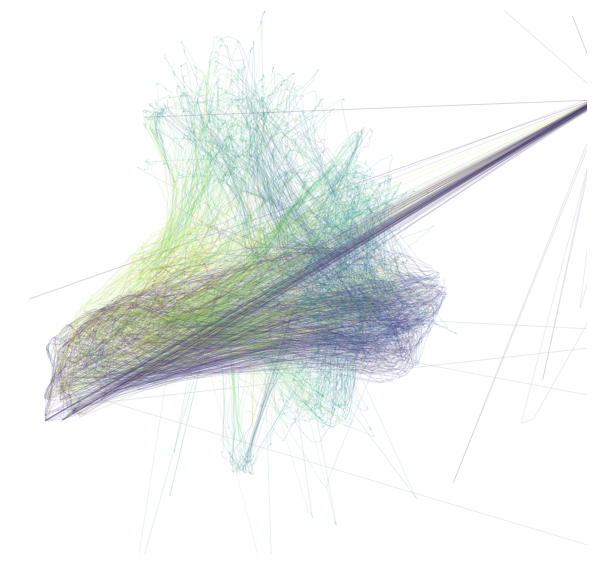

In [28]:
fig, ax = plt.subplots(figsize=(10,10))
#markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in word_pal.values()]
#ax.legend(markers, word_pal.keys(), numpoints=1)


for oi, (on, off) in enumerate(tqdm(zip(onsets, offsets), total=len(offsets))):
    window_z = embedding[on:off,:]
    cols = np.array(sns.color_palette('viridis', len(window_z)))
    #ax.scatter(window_z[:,0], window_z[:,1], alpha = 0.1, s = 1, color=cols)
    colorline(window_z[:,0], window_z[:,1], alpha = 0.1, ax = ax, cmap=plt.cm.viridis, linewidth=1)
    #if oi > 1000:
    #    break
ax.set_xlim(xlims);
ax.set_ylim(ylims);
ax.axis('off')

if savefig: save_fig(FIG_SAVE_LOC / 'trajectory', save_png=True)

### plot by word

In [29]:
len(np.unique(words))

2

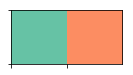

In [30]:
pal = sns.color_palette('Set2', len(np.unique(words)))
sns.palplot(pal)
word_pal = {word:pal[wordi] for wordi, word in enumerate(np.unique(words))}

In [31]:
word_pal

{'take': (0.4, 0.7607843137254902, 0.6470588235294118),
 'talk': (0.9882352941176471, 0.5529411764705883, 0.3843137254901961)}

In [32]:
cols = [word_pal[i] for i in words]

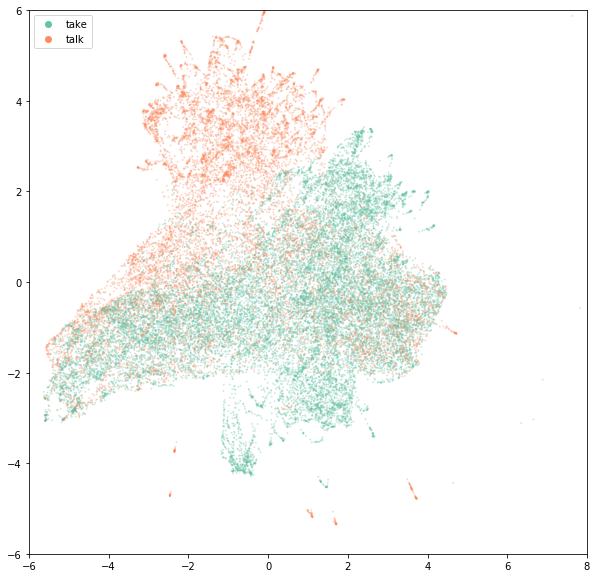

In [33]:
fig, ax = plt.subplots(figsize=(10,10))
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in word_pal.values()]
ax.legend(markers, word_pal.keys(), numpoints=1)

ax.scatter(embedding[:,0], embedding[:,1], alpha = 0.25, s = 1, color=cols)
ax.set_xlim(xlims);
ax.set_ylim(ylims);

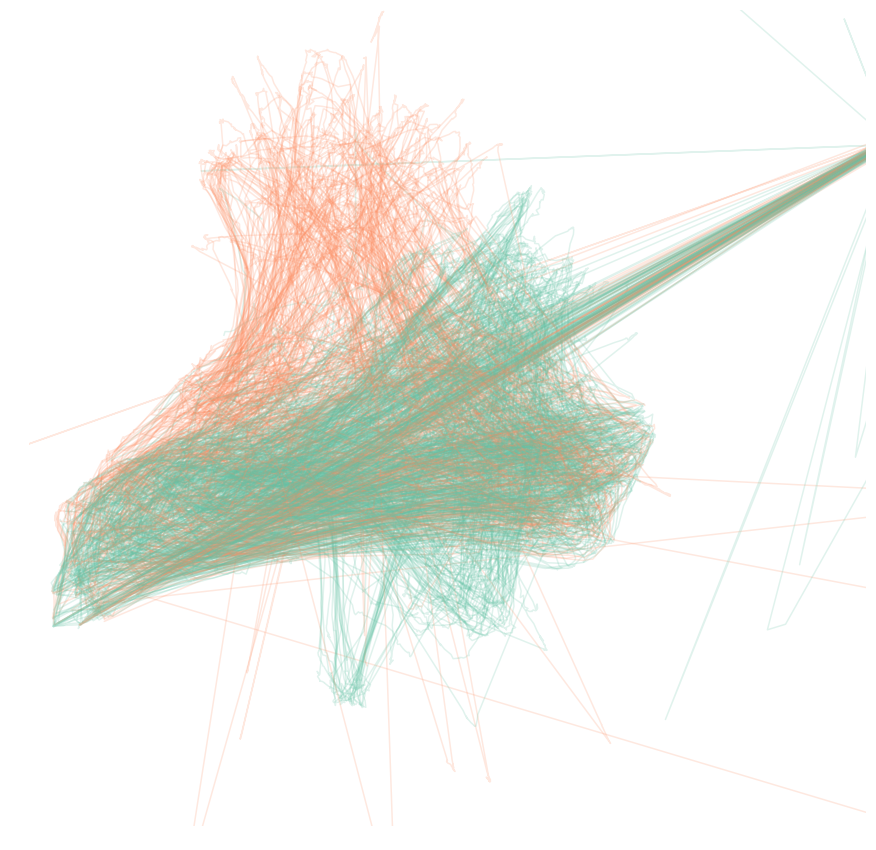

In [34]:
fig, ax = plt.subplots(figsize=(15,15))
#markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in word_pal.values()]
#ax.legend(markers, word_pal.keys(), numpoints=1)

cols = [word_pal[i] for i in words]
for oi, (on, off) in enumerate(tqdm(zip(onsets, offsets), total=len(offsets))):
    window_z = embedding[on:off,:]
    ax.plot(window_z[:,0], window_z[:,1], alpha = 0.2, color=word_pal[words_df.word.values[oi]])
    #if oi > 1000:
    #    break
ax.set_xlim(xlims);
ax.set_ylim(ylims);
ax.axis('off')

if savefig: save_fig(FIG_SAVE_LOC / 'words_trajectory', save_png=True)

### plot the average over each vector for word

In [35]:
from scipy.interpolate import interp1d

In [36]:
#fig, ax = plt.subplots(figsize=(5,5))
word_list = []
word_embedding_list = []
for oi, (word, on, off) in enumerate(tqdm(zip(words_df.word, onsets, offsets), total=len(offsets))):

    window_z = embedding[on:off,:]
    
    word_list.append(word)
    
    f1 = interp1d(np.linspace(0,1, len(window_z)), window_z.T, kind='linear')
    interp_window_z = f1(np.linspace(0,1, 100)).T
    
    word_embedding_list.append(interp_window_z)
    
    #ax.scatter(window_z[:,0], window_z[:,1], alpha = 1, s = 25, color=phone_pal[phone])
    #ax.scatter(interp_window_z[:,0], interp_window_z[:,1], alpha = 1, s = 25, color=phone_pal[phone])
word_embedding_list = np.array(word_embedding_list)
word_list = np.array(word_list)

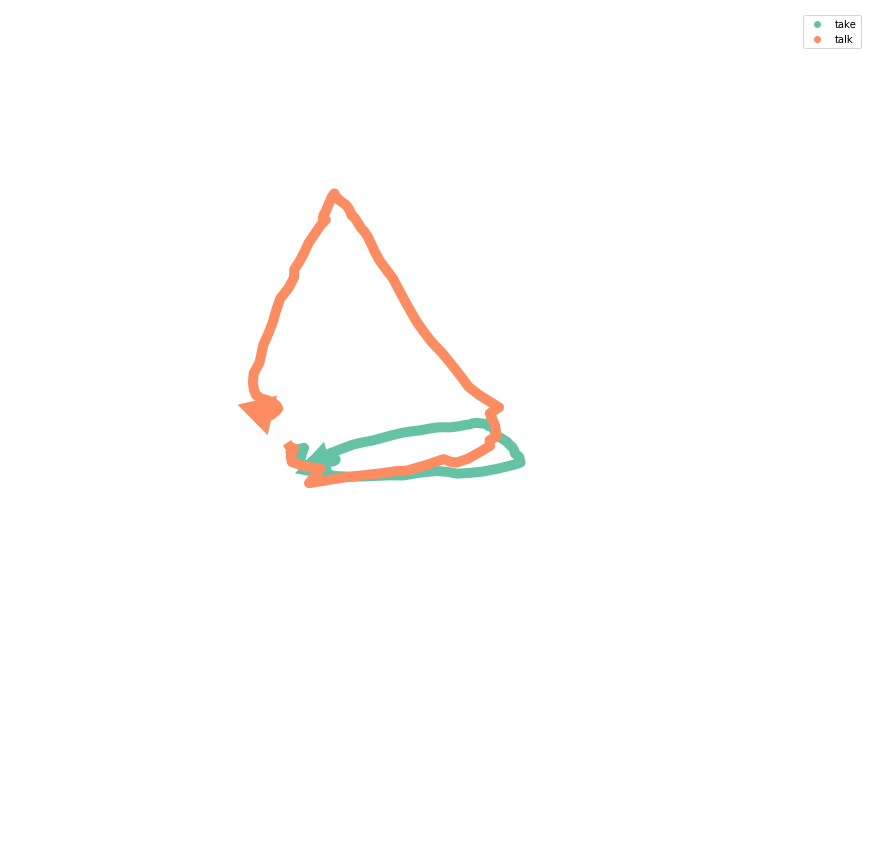

In [37]:
fig, ax = plt.subplots(figsize=(15, 15))
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in word_pal.values()]
ax.legend(markers, word_pal.keys(), numpoints=1)


for word in np.unique(word_list):
    mean_embedding = np.mean(word_embedding_list[word_list == word], axis=0)
    ax.plot(
        mean_embedding[:, 0],
        mean_embedding[:, 1],
        alpha=1,
        lw=10,
        color=word_pal[word],
    )
    ax.arrow(
        mean_embedding[-2, 0],
        mean_embedding[-2, 1],
        #mean_embedding[-1, 0] - mean_embedding[-2, 0],
        #mean_embedding[-1, 1] - mean_embedding[-2, 1],
        mean_embedding[-1, 0] - mean_embedding[-2, 0],
        mean_embedding[-1, 1] - mean_embedding[-2, 1],
        head_width=.5,
        head_length=.5,
        linewidth=4,
        color=word_pal[word],
        length_includes_head=False,
    )

ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.axis('off')
if savefig: save_fig(FIG_SAVE_LOC / 'words_vector', save_png=True, save_svg=True)

### color by phonemes

In [38]:
#make a list of phones, onsets, and offsets for each phone
# for each word, for each phone, get start time and end time in frames

In [39]:
window_length_ms = 4
hop_length_ms = 4
window_length_frames = int(window_length_ms / hop_length_ms)
window_length_frames

1

In [40]:
phones = []
phone_onsets = []
phone_offsets = []
for wdsi, (idx, row) in tqdm(enumerate(words_df.iterrows()), total= len(words_df)):
    cur_windows = len(row.windows)
    phone_start_frame = [0]
    phone_end_frame = []
    for pi, (phone, pst, pet) in enumerate(zip(row.phones, row.phone_start_times, row.phone_end_times)):
        phone_end_frame.append(int(pet / (window_length_ms / 1000)))
        if pi < len(row.phones)-1:
            phone_start_frame.append(phone_end_frame[-1]+1)
    
    phone_onsets.append(np.array(phone_start_frame) + np.sum([0] + n_windows[:wdsi]))
    phone_offsets.append(np.array(phone_end_frame) + np.sum([0] + n_windows[:wdsi]))
    phones.append(row.phones)
phones = np.concatenate(phones)    
phone_onsets = np.concatenate(phone_onsets)
phone_offsets = np.concatenate(phone_offsets)

In [41]:
print(phones[:15], phone_onsets[:15], phone_offsets[:15])

['t' 'ao' 'k' 't' 'ey' 'k' 't' 'ey' 'k' 't' 'ey' 'k' 't' 'ey' 'k'] [  0  38  59  77  96 112 120 147 172 183 220 234 258 284 311] [ 37  58  76  95 111 119 146 171 182 219 233 257 283 310 330]


In [63]:
common_phones = pd.DataFrame({i:[sum(phones == i)] for i in np.unique(phones)}).T.sort_values(by=0, ascending=False)[:4].T
common_phones

t    k   ey   ao
0  511  484  328  149

In [64]:
common_phones.columns

Index(['t', 'k', 'ey', 'ao'], dtype='object')

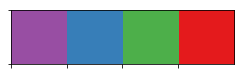

In [65]:
pal = np.random.permutation(sns.color_palette('Set1', len(common_phones.columns)))
sns.palplot(pal)
phone_pal = {word:pal[wordi] for wordi, word in enumerate(common_phones.columns)}

In [66]:
phone_pal[phone]

array([0.59607843, 0.30588235, 0.63921569])

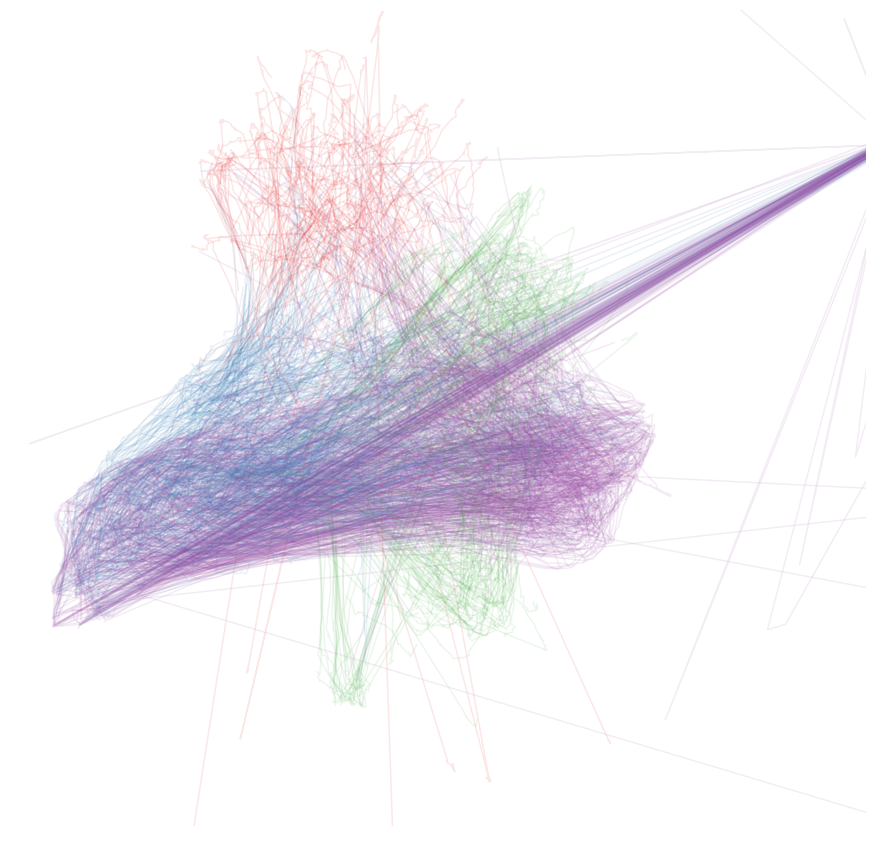

In [67]:
fig, ax = plt.subplots(figsize=(15,15))
#markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in phone_pal.values()]
#ax.legend(markers, phone_pal.keys(), numpoints=1)

for oi, (phone, on, off) in enumerate(tqdm(zip(phones, phone_onsets, phone_offsets), total=len(phone_offsets))):
    if phone not in common_phones.columns:
        continue
    window_z = embedding[on:off,:]
    ax.plot(window_z[:,0], window_z[:,1], alpha = 0.1, color=phone_pal[phone])
    #if oi > 1000:
    #    break
ax.set_xlim(xlims);
ax.set_ylim(ylims);
ax.axis('off')

if savefig: save_fig(FIG_SAVE_LOC / 'phones_trajectory', save_png=True, save_svg=False)

### plot the average vector for each phone

In [68]:
len(np.linspace(0,1, len(window_z)))

19

In [69]:
np.shape(interp_window_z)

(100, 2)

In [70]:
len(window_z)

19

In [71]:
#fig, ax = plt.subplots(figsize=(5,5))
phone_list = []
embedding_list = []
for oi, (phone, on, off) in enumerate(tqdm(zip(phones, phone_onsets, phone_offsets), total=len(phone_offsets))):
    if phone not in common_phones.columns:
        continue
    window_z = embedding[on:off,:]
    if len(window_z) == 1: continue
    phone_list.append(phone)
    
    f1 = interp1d(np.linspace(0,1, len(window_z)), window_z.T, kind='linear')
    interp_window_z = f1(np.linspace(0,1, 100)).T
    
    embedding_list.append(interp_window_z)
    
    #ax.scatter(window_z[:,0], window_z[:,1], alpha = 1, s = 25, color=phone_pal[phone])
    #ax.scatter(interp_window_z[:,0], interp_window_z[:,1], alpha = 1, s = 25, color=phone_pal[phone])
embedding_list = np.array(embedding_list)
phone_list = np.array(phone_list)

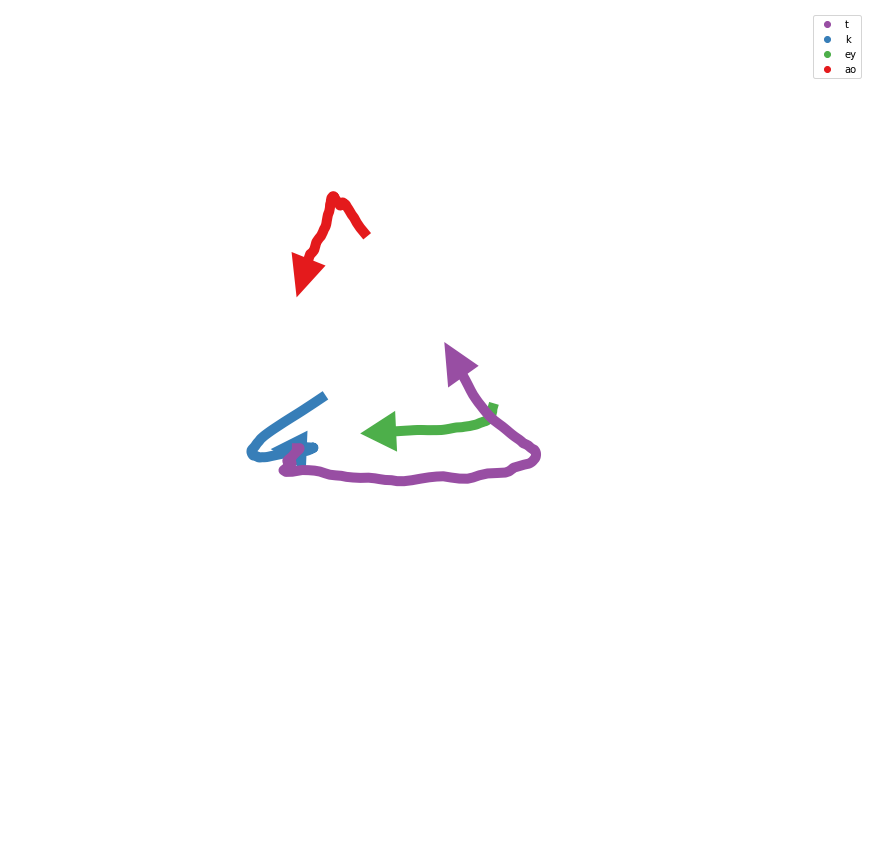

In [72]:
fig, ax = plt.subplots(figsize=(15, 15))
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in phone_pal.values()]
ax.legend(markers, phone_pal.keys(), numpoints=1)


for phone in np.unique(phone_list):
    mean_embedding = np.mean(embedding_list[phone_list == phone], axis=0)
    ax.plot(
        mean_embedding[:, 0],
        mean_embedding[:, 1],
        alpha=1,
        lw=10,
        color=phone_pal[phone],
    )
    ax.arrow(
        mean_embedding[-2, 0],
        mean_embedding[-2, 1],
        #mean_embedding[-1, 0] - mean_embedding[-2, 0],
        #mean_embedding[-1, 1] - mean_embedding[-2, 1],
        mean_embedding[-1, 0] - mean_embedding[-2, 0],
        mean_embedding[-1, 1] - mean_embedding[-2, 1],
        head_width=.5,
        head_length=.5,
        linewidth=4,
        color=phone_pal[phone],
        length_includes_head=False,
    )

ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.axis('off')

if savefig: save_fig(FIG_SAVE_LOC / 'phones_vector', save_png=True, save_svg=True)

### individual differences

In [52]:
words_df[:3]

start_time    end_time  word      phones  \
74    50.261883   50.568774  talk  [t, ao, k]   
178   99.314583   99.484905  take  [t, ey, k]   
227  116.483044  116.734831  take  [t, ey, k]   

                                   phone_start_times  \
74   [0.0, 0.15110900000000527, 0.23211600000000487]   
178   [0.0, 0.0757289999999955, 0.13864599999999427]   
227  [0.0, 0.10627999999999815, 0.20560199999999895]   

                                       phone_end_times  utterance_number  \
74   [0.15110900000000527, 0.23211600000000487, 0.3...                15   
178  [0.0757289999999955, 0.13864599999999427, 0.17...                16   
227  [0.10627999999999815, 0.20560199999999895, 0.2...                64   

     position_in_utterance  word_number indv  indvi age sex     key   rate  \
74                       7            7  s25      0   o   f  s2501b  16000   
178                      7            7  s25      0   o   f  s2501b  16000   
227                     27           27  s25      0   o   f  s2501b  16000   

                                           spectrogram  \
74   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
178  [[13, 13, 14, 14, 11, 9, 28, 59, 118, 156, 175...   
227  [[96, 117, 120, 112, 97, 75, 41, 7, 1, 0, 0, 0...   

                                               windows  
74   [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...  
178  [[[13, 33, 0, 0, 11, 1, 0, 0, 0, 0, 0, 0, 0, 0...  
227  [[[96, 126, 59, 85, 67, 55, 63, 58, 53, 55, 58...

In [53]:
indv_count = pd.DataFrame({i:[sum(words_df.indv ==i)] for i in  words_df.indv.unique()}).T.sort_values(by=0, ascending=False)[:20].T
indv_count

s10  s12  s38  s19  s16  s07  s04  s15  s39  s32  s13  s25  s21  s28  s02  \
0   27   23   23   23   22   20   20   19   19   18   18   17   16   16   16   

   s24  s35  s36  s29  s18  
0   16   14   13   13   12

In [54]:
top_indvs = list(indv_count.columns)

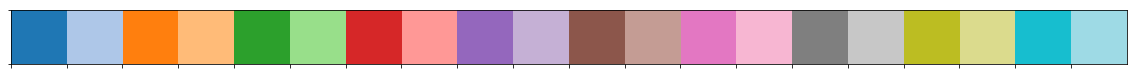

In [55]:
pal = sns.color_palette('tab20', len(top_indvs))
sns.palplot(pal)
indv_pal = {word:pal[wordi] for wordi, word in enumerate(top_indvs)}

In [56]:
#fig, ax = plt.subplots(figsize=(5,5))
indv_list = []
sex_list = []
word_list = []
word_embedding_list = []
for oi, (indv, sex, word, on, off) in enumerate(tqdm(zip(words_df.indv, words_df.sex, words_df.word, onsets, offsets), total=len(offsets))):
    indv = words_df.indv.values[oi]
    if indv not in top_indvs:
        continue
        
    window_z = embedding[on:off,:]
    
    word_list.append(word)
    
    f1 = interp1d(np.linspace(0,1, len(window_z)), window_z.T, kind='linear')
    interp_window_z = f1(np.linspace(0,1, 100)).T
    
    word_embedding_list.append(interp_window_z)
    sex_list.append(sex)
    indv_list.append(indv)
    #ax.scatter(window_z[:,0], window_z[:,1], alpha = 1, s = 25, color=phone_pal[phone])
    #ax.scatter(interp_window_z[:,0], interp_window_z[:,1], alpha = 1, s = 25, color=phone_pal[phone])
word_embedding_list = np.array(word_embedding_list)
word_list = np.array(word_list)
sex_list = np.array(sex_list)
indv_list = np.array(indv_list)

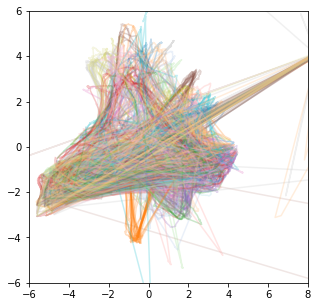

In [57]:
fig, ax = plt.subplots(figsize=(5,5))

cols = [word_pal[i] for i in words]
for oi, (on, off) in enumerate(tqdm(zip(onsets, offsets), total=len(offsets))):
    indv = words_df.indv.values[oi]
    if indv not in top_indvs:
        continue
    #print(indv)
    window_z = embedding[on:off,:]
    ax.plot(window_z[:,0], window_z[:,1], alpha = 0.25, color=indv_pal[indv])
ax.set_xlim(xlims);
ax.set_ylim(ylims);

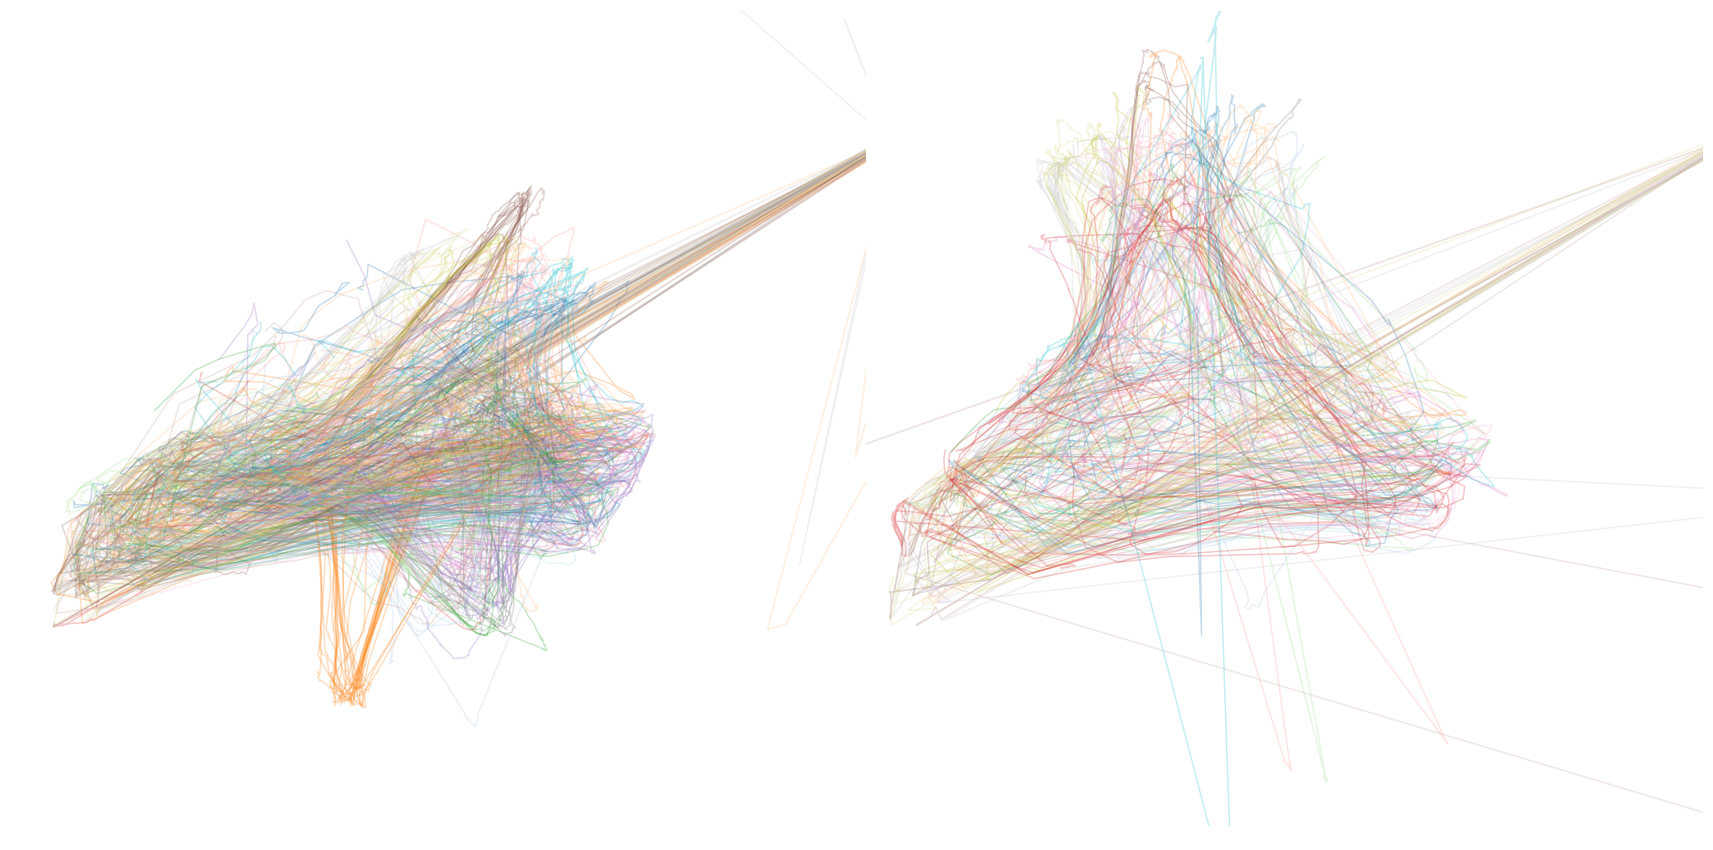

In [58]:
fig, axs = plt.subplots(
    ncols=len(np.unique(word_list)),
    figsize=(15 * len(np.unique(word_list)), 15),
    gridspec_kw={"wspace": 0, "hspace": 0},
)

cols = [word_pal[i] for i in words]
for oi, (on, off) in enumerate(tqdm(zip(onsets, offsets), total=len(offsets))):
    ax = axs.flatten()[np.where(words_df.word.values[oi] == np.unique(word_list))[0][0]]
    indv = words_df.indv.values[oi]
    if indv not in top_indvs:
        continue
    window_z = embedding[on:off, :]
    ax.plot(
        window_z[:, 0],
        window_z[:, 1],
        alpha=0.25,
        color=indv_pal[words_df.indv.values[oi]],
    )
for ax in axs.flatten():
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.axis('off')
    
if savefig: save_fig(FIG_SAVE_LOC / 'indv_trajectory', save_png=True, save_svg=False)

In [59]:
from random import sample 

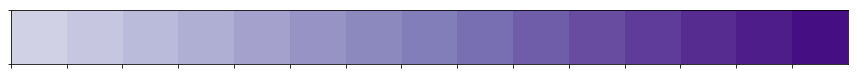

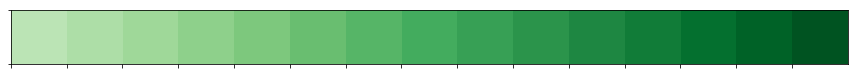

In [61]:
blue_pal = sns.color_palette('Purples', 20)[5:]
red_pal = sns.color_palette('Greens', 20)[5:]
sns.palplot(blue_pal)
sns.palplot(red_pal)

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


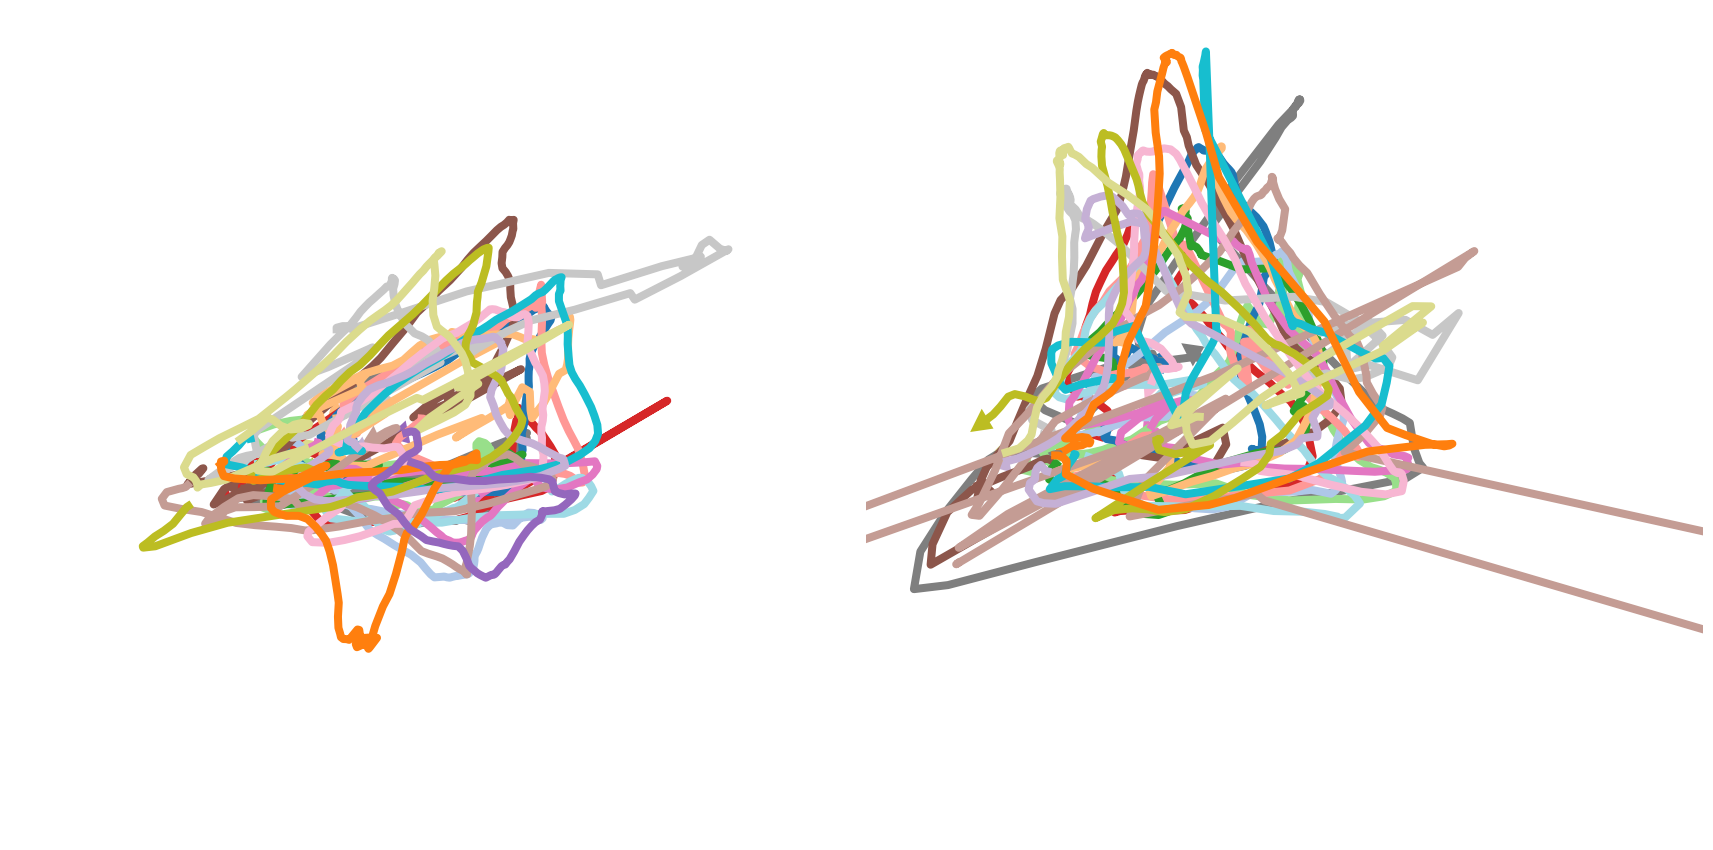

In [62]:
fig, axs = plt.subplots(
    ncols=len(np.unique(word_list)),
    figsize=(15 * len(np.unique(word_list)), 15),
    gridspec_kw={"wspace": 0, "hspace": 0},
)
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in word_pal.values()]
"""ax.legend(markers, word_pal.keys(), numpoints=1)
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in word_pal.values()]


ax.legend(markers, word_pal.keys(), numpoints=1)

cols = [word_pal[i] for i in words]
for oi, (on, off) in enumerate(tqdm(zip(onsets, offsets), total=len(offsets))):
    window_z = embedding[on:off,:]
    ax.plot(window_z[:,0], window_z[:,1], alpha = 0.1, color=sex_pal[words_df.sex.values[oi]])
    """
for indv in np.unique(indv_list):
    if indv not in top_indvs:
        continue
    sex = words_df[words_df.indv == indv].sex.values[0]
    for wi, word in enumerate(np.unique(word_list)):
        mean_embedding = np.mean(word_embedding_list[(word_list == word) & (indv_list == indv)], axis=0)
        ax = axs.flatten()[wi]
        
        if sex == 'm':
            color = sample(blue_pal, 1)[0]
        else:
            color = sample(red_pal, 1)[0]
        ax.plot(
            mean_embedding[:, 0],
            mean_embedding[:, 1],
            alpha=1,
            lw=8,
            color=indv_pal[indv], #color, #sex_pal[sex],#indv_pal[indv],
            #ls = {'m': 'dotted', 'f':'dashed'}[sex]
        )
        ax.arrow(
            mean_embedding[-2, 0],
            mean_embedding[-2, 1],
            #mean_embedding[-1, 0] - mean_embedding[-2, 0],
            #mean_embedding[-1, 1] - mean_embedding[-2, 1],
            mean_embedding[-1, 0] - mean_embedding[-2, 0],
            mean_embedding[-1, 1] - mean_embedding[-2, 1],
            head_width=.25,
            head_length=.25,
            linewidth=4,
            color=indv_pal[indv], #color, #sex_pal[sex],#indv_pal[indv],
            length_includes_head=False,
        )
        #ax.set_title(word)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.axis('off')
if savefig: save_fig(FIG_SAVE_LOC / 'indv_vector', save_png=True, save_svg=True)

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


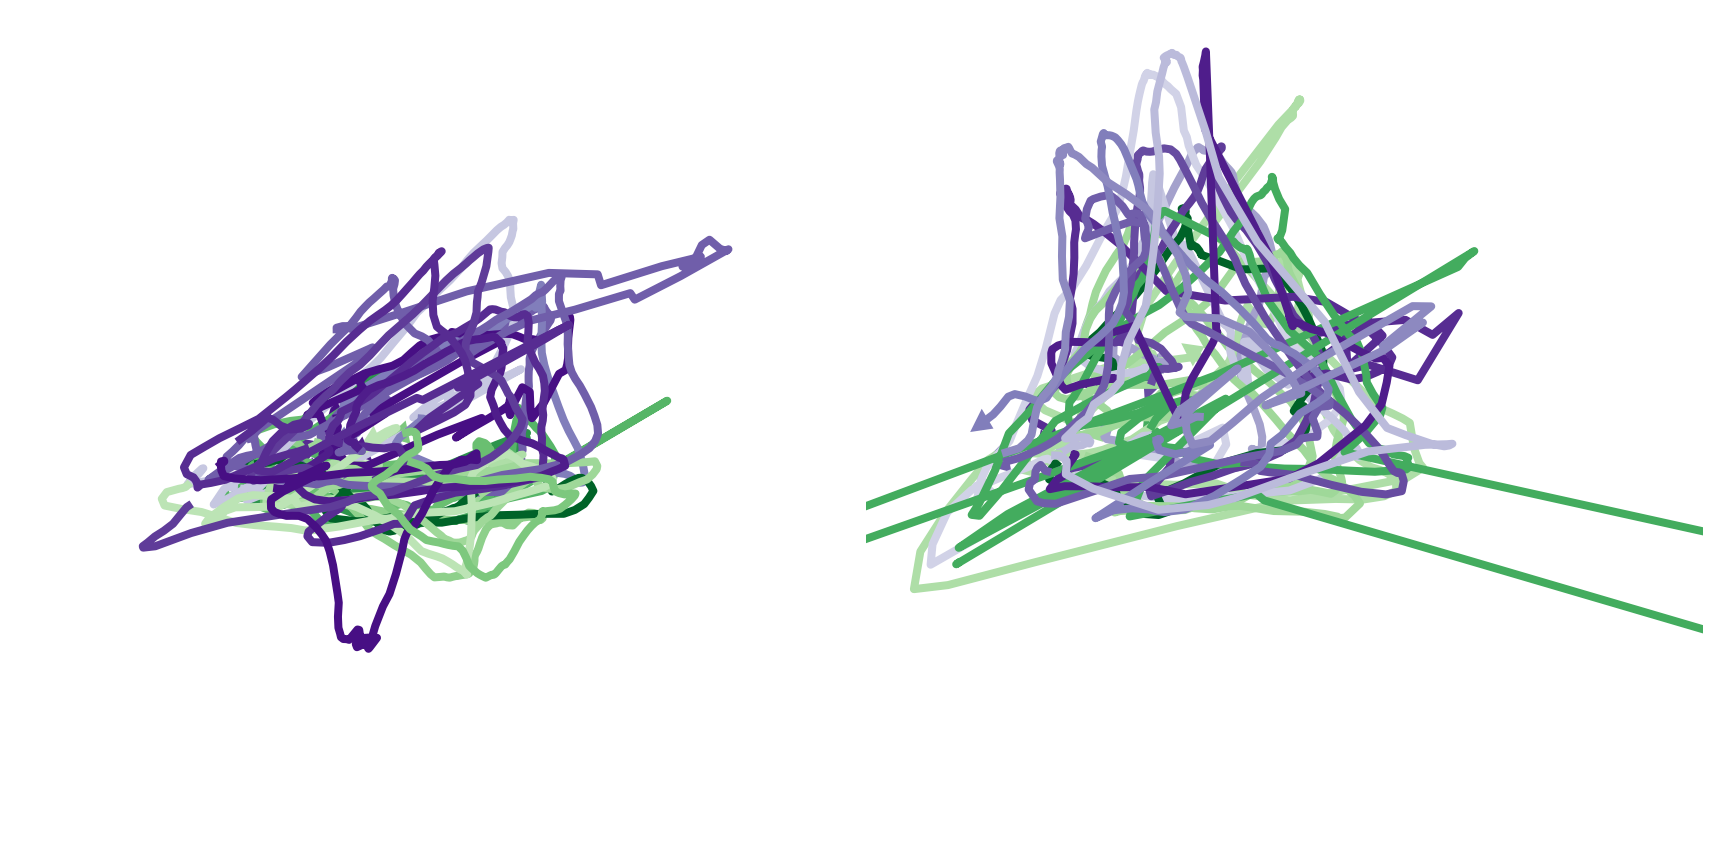

In [73]:
fig, axs = plt.subplots(
    ncols=len(np.unique(word_list)),
    figsize=(15 * len(np.unique(word_list)), 15),
    gridspec_kw={"wspace": 0, "hspace": 0},
)
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in word_pal.values()]
"""ax.legend(markers, word_pal.keys(), numpoints=1)
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in word_pal.values()]


ax.legend(markers, word_pal.keys(), numpoints=1)

cols = [word_pal[i] for i in words]
for oi, (on, off) in enumerate(tqdm(zip(onsets, offsets), total=len(offsets))):
    window_z = embedding[on:off,:]
    ax.plot(window_z[:,0], window_z[:,1], alpha = 0.1, color=sex_pal[words_df.sex.values[oi]])
    """
for indv in np.unique(indv_list):
    if indv not in top_indvs:
        continue
    sex = words_df[words_df.indv == indv].sex.values[0]
    for wi, word in enumerate(np.unique(word_list)):
        mean_embedding = np.mean(word_embedding_list[(word_list == word) & (indv_list == indv)], axis=0)
        ax = axs.flatten()[wi]
        
        if sex == 'm':
            color = sample(blue_pal, 1)[0]
        else:
            color = sample(red_pal, 1)[0]
        ax.plot(
            mean_embedding[:, 0],
            mean_embedding[:, 1],
            alpha=1,
            lw=8,
            color=color, #sex_pal[sex],#indv_pal[indv],
            #ls = {'m': 'dotted', 'f':'dashed'}[sex]
        )
        ax.arrow(
            mean_embedding[-2, 0],
            mean_embedding[-2, 1],
            #mean_embedding[-1, 0] - mean_embedding[-2, 0],
            #mean_embedding[-1, 1] - mean_embedding[-2, 1],
            mean_embedding[-1, 0] - mean_embedding[-2, 0],
            mean_embedding[-1, 1] - mean_embedding[-2, 1],
            head_width=.25,
            head_length=.25,
            linewidth=4,
            color=color, #sex_pal[sex],#indv_pal[indv],
            length_includes_head=False,
        )
        #ax.set_title(word)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.axis('off')
if savefig: save_fig(FIG_SAVE_LOC / 'indv_sex_vector', save_png=True, save_svg=True)

### sex differences

In [74]:
words_df[:3]

start_time    end_time  word      phones  \
74    50.261883   50.568774  talk  [t, ao, k]   
178   99.314583   99.484905  take  [t, ey, k]   
227  116.483044  116.734831  take  [t, ey, k]   

                                   phone_start_times  \
74   [0.0, 0.15110900000000527, 0.23211600000000487]   
178   [0.0, 0.0757289999999955, 0.13864599999999427]   
227  [0.0, 0.10627999999999815, 0.20560199999999895]   

                                       phone_end_times  utterance_number  \
74   [0.15110900000000527, 0.23211600000000487, 0.3...                15   
178  [0.0757289999999955, 0.13864599999999427, 0.17...                16   
227  [0.10627999999999815, 0.20560199999999895, 0.2...                64   

     position_in_utterance  word_number indv  indvi age sex     key   rate  \
74                       7            7  s25      0   o   f  s2501b  16000   
178                      7            7  s25      0   o   f  s2501b  16000   
227                     27           27  s25      0   o   f  s2501b  16000   

                                           spectrogram  \
74   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
178  [[13, 13, 14, 14, 11, 9, 28, 59, 118, 156, 175...   
227  [[96, 117, 120, 112, 97, 75, 41, 7, 1, 0, 0, 0...   

                                               windows  
74   [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...  
178  [[[13, 33, 0, 0, 11, 1, 0, 0, 0, 0, 0, 0, 0, 0...  
227  [[[96, 126, 59, 85, 67, 55, 63, 58, 53, 55, 58...

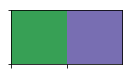

In [75]:
pal = [red_pal[8], blue_pal[8]]
sns.palplot(pal)
sex_pal = {word:pal[wordi] for wordi, word in enumerate(np.unique(words_df.sex))}

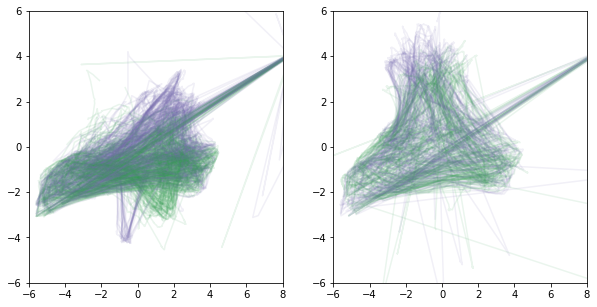

In [76]:
fig, axs = plt.subplots(ncols = len(np.unique(word_list)), figsize=(5*len(np.unique(word_list)), 5))

cols = [word_pal[i] for i in words]
for oi, (on, off) in enumerate(tqdm(zip(onsets, offsets), total=len(offsets))):
    ax = axs.flatten()[np.where(words_df.word.values[oi] == np.unique(word_list))[0][0]]
    window_z = embedding[on:off,:]
    ax.plot(window_z[:,0], window_z[:,1], alpha = 0.1, color=sex_pal[words_df.sex.values[oi]])
    #if oi > 1000:
    #    break
for ax in axs.flatten():
    ax.set_xlim(xlims);
    ax.set_ylim(ylims);

In [77]:
#fig, ax = plt.subplots(figsize=(5,5))
sex_list = []
word_list = []
word_embedding_list = []
for oi, (sex, word, on, off) in enumerate(tqdm(zip(words_df.sex, words_df.word, onsets, offsets), total=len(offsets))):

    window_z = embedding[on:off,:]
    
    word_list.append(word)
    
    f1 = interp1d(np.linspace(0,1, len(window_z)), window_z.T, kind='linear')
    interp_window_z = f1(np.linspace(0,1, 100)).T
    
    word_embedding_list.append(interp_window_z)
    sex_list.append(sex)
    #ax.scatter(window_z[:,0], window_z[:,1], alpha = 1, s = 25, color=phone_pal[phone])
    #ax.scatter(interp_window_z[:,0], interp_window_z[:,1], alpha = 1, s = 25, color=phone_pal[phone])
word_embedding_list = np.array(word_embedding_list)
word_list = np.array(word_list)
sex_list = np.array(sex_list)

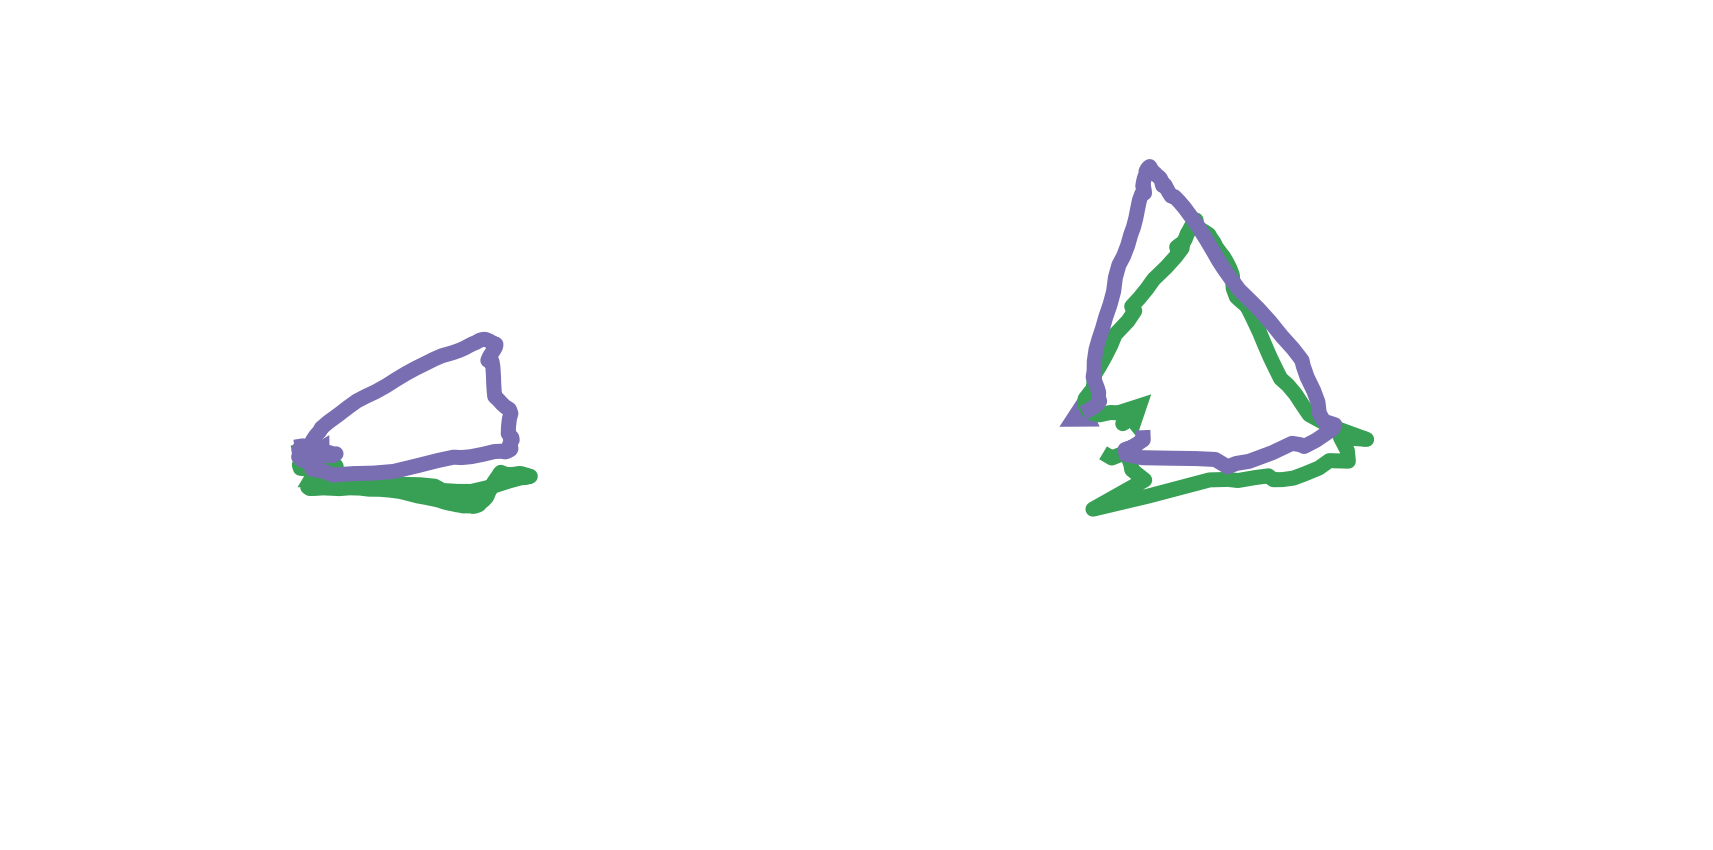

In [78]:
fig, axs = plt.subplots(
    ncols=len(np.unique(word_list)),
    figsize=(15 * len(np.unique(word_list)), 15),
    gridspec_kw={"wspace": 0, "hspace": 0},
)
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in word_pal.values()]
"""ax.legend(markers, word_pal.keys(), numpoints=1)
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in word_pal.values()]


ax.legend(markers, word_pal.keys(), numpoints=1)

cols = [word_pal[i] for i in words]
for oi, (on, off) in enumerate(tqdm(zip(onsets, offsets), total=len(offsets))):
    window_z = embedding[on:off,:]
    ax.plot(window_z[:,0], window_z[:,1], alpha = 0.1, color=sex_pal[words_df.sex.values[oi]])
    """
for sex in np.unique(sex_list):
    for wi, word in enumerate(np.unique(word_list)):
        mean_embedding = np.mean(word_embedding_list[(word_list == word) & (sex_list == sex)], axis=0)
        ax = axs.flatten()[wi]
        ax.plot(
            mean_embedding[:, 0],
            mean_embedding[:, 1],
            alpha=1,
            lw=15,
            color=sex_pal[sex],
            #ls = {'m': 'dotted', 'f':'dashed'}[sex]
        )
        ax.arrow(
            mean_embedding[-2, 0],
            mean_embedding[-2, 1],
            #mean_embedding[-1, 0] - mean_embedding[-2, 0],
            #mean_embedding[-1, 1] - mean_embedding[-2, 1],
            mean_embedding[-1, 0] - mean_embedding[-2, 0],
            mean_embedding[-1, 1] - mean_embedding[-2, 1],
            head_width=.5,
            head_length=.5,
            linewidth=4,
            color=sex_pal[sex],
            length_includes_head=False,
        )
        #ax.set_title(word)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.axis('off')
if savefig: save_fig(FIG_SAVE_LOC / 'sex_vector', save_png=True, save_svg=True)

### spectrograms vs embeddings in colorspace

In [79]:
# plot segment labels alongside phone labels

In [80]:
import copy

In [81]:
def norm(x):
    return (x-np.min(x))/(np.max(x)-np.min(x))

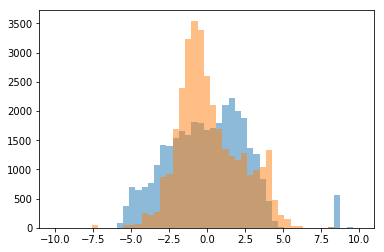

In [82]:
z_normed = copy.deepcopy(embedding)
plt.hist(z_normed[:,0], bins = np.linspace(-10,10, 50), alpha = 0.5);
plt.hist(z_normed[:,1], bins = np.linspace(-10,10, 50), alpha = 0.5);

In [83]:
xlims = [-5,5]
ylims = [-5,5]

In [84]:
z_normed[:,0][z_normed[:,0] > xlims[1]] = xlims[1]
z_normed[:,0][z_normed[:,0] < xlims[0]] = xlims[0]
z_normed[:,1][z_normed[:,1] > ylims[1]] = ylims[1]
z_normed[:,1][z_normed[:,1] < ylims[0]] = ylims[0]

z_normed[:,0] = norm(z_normed[:,0])
z_normed[:,1] = norm(z_normed[:,1])

In [85]:
window_z = z_normed
R = 1-norm(window_z[:,0])#*.75 + .25
G = 1-norm(window_z[:,1])#*.75 + .25
B = np.ones_like(G)*.5
RGB = np.dstack((R,G,B))
RGB = [list(i) for i in np.nan_to_num(np.squeeze(RGB))]
rgb_img = np.expand_dims(RGB,0)

In [86]:
phone_pal

{'t': array([0.59607843, 0.30588235, 0.63921569]),
 'k': array([0.21568627, 0.49411765, 0.72156863]),
 'ey': array([0.30196078, 0.68627451, 0.29019608]),
 'ao': array([0.89411765, 0.10196078, 0.10980392])}

In [87]:
np.shape(rgb_img)

(1, 33548, 3)

In [88]:
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
from matplotlib import gridspec

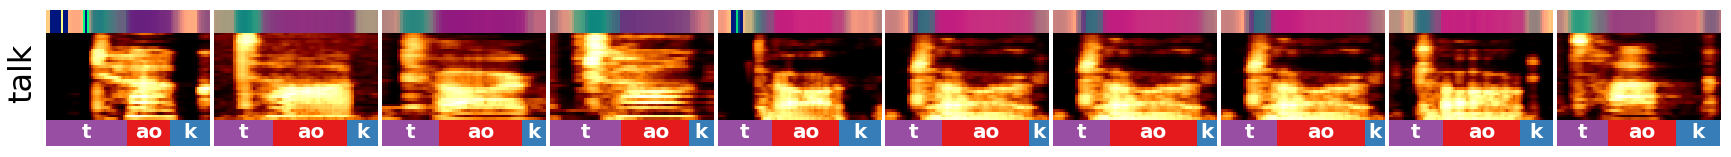

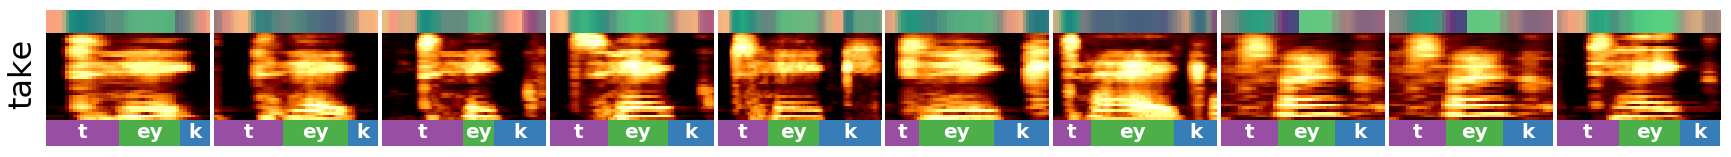

In [89]:
ncols = 10
for wi, word in enumerate(words_df.word.unique()):
    
    fig = plt.figure(figsize=((ncols)*3, 2.5)) 
    gs = gridspec.GridSpec(2, ncols, height_ratios=[1, 5]) 
    gs.update(wspace=0.025, hspace=0)
    
    for ci,col in enumerate(range(ncols)):
       
    
        row = words_df[words_df.word == word].iloc[col]
        
        while np.all([i in phone_pal for i in row.phones]) == False:
            col = col + 1
            row = words_df[words_df.word == word].iloc[col]
        
        ### plot projections
        ax = plt.subplot(gs[0, ci]) #axs[col]
        # subset embedding 
        on = onsets[np.where(words_df.index == row.name)[0][0]]
        off = offsets[np.where(words_df.index == row.name)[0][0]]

        ax.imshow(rgb_img[:,on:off, :], aspect='auto')
        
        ax.axis('off')
        ### plot spec
        ax = plt.subplot(gs[1, ci]) #axs[col]
        if ci == 0: 
            ax.set_ylabel(word, fontsize=32)
            ax.yaxis.set_label_coords(-0.05,.65)
        spec = row.spectrogram
        ax.matshow(spec, aspect='auto', origin='lower', extent = [0, row.end_time - row.start_time, 0,1], cmap = plt.cm.afmhot)
        ax.set_ylim([-.3,1])
        for spine in ax.spines:
            ax.spines[spine].set_visible(False)
        for phone, st, et in zip(row.phones, row.phone_start_times, row.phone_end_times):
            
            ax.add_patch(
            mpatches.Rectangle(
                [st, -.3],
                et - st,
                .3,
                ec="none",
                color=phone_pal[phone],
            )
            )
            ax.text((st + et)/2, -.2, phone, color='w', fontsize=20, horizontalalignment='center', weight='bold')
            
        ax.set_xticks([])
        ax.set_yticks([])
        #ax.axis('off')
    if savefig: save_fig(FIG_SAVE_LOC / ('spec_' + word), save_png=True, save_svg=True)
    plt.show()

In [90]:
spine

'top'

In [91]:
row

start_time                                                         28.7111
end_time                                                           28.9625
word                                                                  take
phones                                                          [t, ey, k]
phone_start_times          [0.0, 0.09509900000000115, 0.18900500000000164]
phone_end_times          [0.09509900000000115, 0.18900500000000164, 0.2...
utterance_number                                                        19
position_in_utterance                                                    8
word_number                                                              8
indv                                                                   s16
indvi                                                                    0
age                                                                      o
sex                                                                      f
key                      